##### Author: Pablo Iañez Picazo
##### Biomedical Data Science lab

In [9]:
# Load all the necessary libraries
import gc
from glob import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from skimage import measure

# Supress all warnings
import warnings

warnings.filterwarnings("ignore")

from methods import hsc_spatial_stats as hsc

In [10]:
def get_nuclear_metrics_2D_slide(mask, im, res):
    """
    Extract intensity measures and morphometrical measures from the given 2D
    slide, along with the nuclear mask
    """

    properties_slide = [
        "area",
        "bbox",
        "centroid",
        "eccentricity",
        "major_axis_length",
        "minor_axis_length",
        "perimeter",
        "perimeter_crofton",
        "equivalent_diameter",
        "feret_diameter_max",
    ]

    label_mask = measure.label(mask)

    # Extract basic features using skimage regionprops
    df = pd.DataFrame(
        measure.regionprops_table(
            label_mask, intensity_image=im, properties=properties_slide
        )
    )

    # turn pixel units into micrometer units
    for m in [
        "equivalent_diameter",
        "feret_diameter_max",
        "major_axis_length",
        "minor_axis_length",
        "perimeter",
        "perimeter_crofton",
    ]:
        df[m] = df[m] * res

    # Compute more features
    df["area"] = df["area"] * (res**2)
    roundness = 4.0 * np.pi * df["area"] / df["perimeter"] ** 2
    df["roundness"] = min(1.0, roundness.values[0])
    df["compactness"] = df["perimeter"] ** (2 / (4.0 * np.pi * df["area"]))
    df["EOP"] = hsc.excess_of_perimeter_ellipse(df)

    return df

In [12]:
# ---------------------- Set up processing parameters ---------------------- #

# Image resolution after resizing, which is 5 micrometers per pixel
res = 0.1

# cluster forming threshold - threshold at which intensities above this value
# will be considered belonging to a DAPI-Intense Region (DIR)
# Intensities to 0.6 are the one in the quantile 0.80 in young, old and treated
cft = 0.6  # ZSCORENORM
norm = "z_score"
folder = "../data/preprocessed"
conditions = [
    "young",
    "aged",
    "aged_treated_RhoAi",
    "young_compressed_8um",
    "young_compressed_5um",
    "myeloid_progenitors",
]

In [13]:
# nuc_df = pd.DataFrame()
nuc_df = pd.read_csv(f"results/{norm}_nuclei_3d_res{res}_cf{cft}_filt_df.csv")

for cond in conditions:
    # Lists .npz files within containing folder with a given prefix
    npz_ims = glob(f"{folder}/3D_res={res}_norm={norm}_npz_filt/{cond}/*.npz")
    print(cond)

    for i, npz in enumerate(npz_ims):
        print(i)
        print(npz)
        image = np.load(npz, allow_pickle=True)
        nuc_mask = image["nuc_mask"].astype(int)
        im = image["img"]
        metadata = image["metadata"].item()

        # Rotate the image and convert to XYZ coordenates
        im, nuc_mask = hsc.from_zxy_to_xyz([im, nuc_mask])

        # max_index = np.argmax(nuc_mask.sum(0).sum(0))
        # plt.imshow(im[:, :, max_index])
        # plt.show()

        df = hsc.get_nuclear_metrics_3D(nuc_mask, im, res)

        # Add information from the largest 2D slide in XY plane
        slide, slide_mask = hsc.get_slide(
            im, nuc_mask, mode="largest", plane="XY"
        )
        slide, slide_mask = [np.rot90(a) for a in (slide, slide_mask)]
        df_slide = get_nuclear_metrics_2D_slide(slide_mask, slide, res)
        df_slide = df_slide.add_prefix("2D_slide_")
        df = pd.concat([df, df_slide], axis=1)

        # Segment with Watershed algorithm
        DIRs_mask = hsc.segment_condensates(
            im, nuc_mask, cluster_thresh=cft, mode="absolute"
        )
        # plt.imshow(DIRs_mask[:, :, max_index])
        # plt.show()

        # If here is at least one segmented DIR
        if not np.count_nonzero(DIRs_mask) == 0:
            df_DIRs = hsc.get_DIRs_metrics_3D(DIRs_mask, im, res)
            DIRs_mask, df_DIRs = hsc.filter_DIRs(
                DIRs_mask, df_DIRs, query="include == False or volume < 0.2"
            )

            # Get the distance mask to nuclear border
            dist2bord = hsc.distance_transform_edt(nuc_mask)

            # Calculate and tabulate distance to edge of each single
            # DIR in the properties table
            df_DIRs = hsc.get_distance_to_edge_by_DIR(
                df_DIRs, dist2bord, DIRs_mask
            )

            # Do the average of all DAPI Intense Regions (DIRs) in this nucleus
            df_DIRs = pd.DataFrame(df_DIRs.mean(axis=0)).T
            df_DIRs = df_DIRs.add_prefix("DIRs_")
            df = pd.concat([df, df_DIRs], axis=1)

        # Add image path and batch for identification later on
        df["res_Z"] = metadata["original_res"]["Z"]
        df["sigma_noise"] = metadata["original_sigma_noise"]
        df["im_path"] = "/".join(npz.split("/")[-3:])
        df["im_batch"] = metadata["batch_id"]
        df["im_nuc"] = metadata["nuc_id"]
        df["condition"] = cond

        # Merge the nucleus and DIRs dataframe into one and save this iteration
        nuc_df = pd.concat([nuc_df, df])
        gc.collect()

    nuc_df.to_csv(f"results/{norm}_nuclei_3d_res{res}_cf{cft}_filt_df.csv")

myeloid_progenitors
0
../data/preprocessed/3D_res=0.1_norm=z_score_npz_filt/myeloid_progenitors/20210120_PHF8-OldAB_nuc_68.npz
1
../data/preprocessed/3D_res=0.1_norm=z_score_npz_filt/myeloid_progenitors/20210414_KDM4B_nuc_59.npz
2
../data/preprocessed/3D_res=0.1_norm=z_score_npz_filt/myeloid_progenitors/20210429_H3K9me2-Cy3_nuc_41.npz
3
../data/preprocessed/3D_res=0.1_norm=z_score_npz_filt/myeloid_progenitors/20211203_KDM3A_nuc_84.npz
4
../data/preprocessed/3D_res=0.1_norm=z_score_npz_filt/myeloid_progenitors/20210429_H3K9me2-Cy3_nuc_16.npz
5
../data/preprocessed/3D_res=0.1_norm=z_score_npz_filt/myeloid_progenitors/20210421_PHF8-OldAB_nuc_35.npz
6
../data/preprocessed/3D_res=0.1_norm=z_score_npz_filt/myeloid_progenitors/20210916_KDM3A_2_nuc_106.npz
7
../data/preprocessed/3D_res=0.1_norm=z_score_npz_filt/myeloid_progenitors/20210421_PHF8-OldAB_nuc_41.npz
8
../data/preprocessed/3D_res=0.1_norm=z_score_npz_filt/myeloid_progenitors/20201109_KDM4B_nuc_34.npz
9
../data/preprocessed/3D_res=0.

In [14]:
nuc_df = pd.read_csv(f"results/{norm}_nuclei_3d_res{res}_cf{cft}_filt_df.csv")
nuc_df = hsc.fix_labels(nuc_df)

nuc_df

,Unnamed: 0.1,Unnamed: 0,equivalent_diameter,feret_diameter_max,bbox-0,bbox-1,bbox-2,bbox-3,bbox-4,bbox-5,...,DIRs_n,DIRs_centroid_distance2border,DIRs_mean_distance2border,DIRs_min_distance2border,res_Z,sigma_noise,im_path,im_batch,im_nuc,condition
0,0,0.0,8.210339,10.433120,3.0,3.0,3.0,83.0,84.0,91.0,...,38.0,6.944179,6.306705,3.007999,0.440813,1.388192,3D_res=0.1_norm=z_score_npz_filt/young/2019112...,20191128PlaminYoung,nuc_20,Young
1,1,0.0,6.248113,8.067837,3.0,3.0,3.0,61.0,64.0,81.0,...,16.0,8.001787,7.108133,2.735228,0.440813,4.035023,3D_res=0.1_norm=z_score_npz_filt/young/2020013...,20200130PlaminYoung slide1exp200122,nuc_13,Young
2,2,0.0,6.561107,7.773030,3.0,3.0,3.0,68.0,75.0,72.0,...,28.0,8.161914,7.387506,3.524641,0.400000,1.833996,3D_res=0.1_norm=z_score_npz_filt/young/2020111...,20201119expRhoAAF488YoungRFPcellsSlide3,nuc_64,Young
3,3,0.0,6.755122,7.609205,3.0,3.0,3.0,75.0,70.0,69.0,...,31.0,7.397762,6.829071,3.126711,0.400000,2.179795,3D_res=0.1_norm=z_score_npz_filt/young/2020121...,20201218expY2RhoAAF488,nuc_29,Young
4,4,0.0,6.082809,7.596052,3.0,3.0,3.0,64.0,69.0,74.0,...,16.0,8.252916,7.401236,3.076838,0.440813,4.099915,3D_res=0.1_norm=z_score_npz_filt/young/2019121...,20191212CDK8YoungSlide9exp20191209,nuc_10,Young
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
862,0,NaN,6.904104,8.690800,3.0,3.0,3.0,64.0,75.0,87.0,...,19.0,7.339017,6.516620,2.842948,0.395000,2.251344,3D_res=0.1_norm=z_score_npz_filt/myeloid_proge...,20210430_PHF8-OldAB,nuc_64,MP
863,0,NaN,7.350661,8.934204,3.0,3.0,3.0,78.0,81.0,74.0,...,35.0,8.424613,7.887871,3.305772,0.395000,1.262082,3D_res=0.1_norm=z_score_npz_filt/myeloid_proge...,20201109_KDM4B,nuc_39,MP
864,0,NaN,6.048062,7.368853,3.0,3.0,3.0,65.0,58.0,74.0,...,9.0,8.333411,6.752278,2.411681,0.395000,1.047728,3D_res=0.1_norm=z_score_npz_filt/myeloid_proge...,20210415_KDM4A,nuc_46,MP
865,0,NaN,6.423256,7.100000,3.0,3.0,3.0,66.0,64.0,73.0,...,20.0,7.420451,6.633559,3.061965,0.395000,1.762048,3D_res=0.1_norm=z_score_npz_filt/myeloid_proge...,20210120_PHF8-OldAB,nuc_66,MP


In [15]:
# Keep the nuclei with only one mask, so no more than 2 cells in the image
nuc_df = nuc_df.drop(["Unnamed: 0", "Unnamed: 0.1"], axis=1)
nuc_df = nuc_df.reset_index(drop=True)
nuc_df = hsc.fix_labels(nuc_df)
nuc_df

,equivalent_diameter,feret_diameter_max,bbox-0,bbox-1,bbox-2,bbox-3,bbox-4,bbox-5,centroid-0,centroid-1,...,DIRs_n,DIRs_centroid_distance2border,DIRs_mean_distance2border,DIRs_min_distance2border,res_Z,sigma_noise,im_path,im_batch,im_nuc,condition
0,8.210339,10.433120,3.0,3.0,3.0,83.0,84.0,91.0,41.424371,42.805900,...,38.0,6.944179,6.306705,3.007999,0.440813,1.388192,3D_res=0.1_norm=z_score_npz_filt/young/2019112...,20191128PlaminYoung,nuc_20,Young
1,6.248113,8.067837,3.0,3.0,3.0,61.0,64.0,81.0,30.735945,31.937361,...,16.0,8.001787,7.108133,2.735228,0.440813,4.035023,3D_res=0.1_norm=z_score_npz_filt/young/2020013...,20200130PlaminYoung slide1exp200122,nuc_13,Young
2,6.561107,7.773030,3.0,3.0,3.0,68.0,75.0,72.0,34.309696,38.035574,...,28.0,8.161914,7.387506,3.524641,0.400000,1.833996,3D_res=0.1_norm=z_score_npz_filt/young/2020111...,20201119expRhoAAF488YoungRFPcellsSlide3,nuc_64,Young
3,6.755122,7.609205,3.0,3.0,3.0,75.0,70.0,69.0,40.622821,36.035886,...,31.0,7.397762,6.829071,3.126711,0.400000,2.179795,3D_res=0.1_norm=z_score_npz_filt/young/2020121...,20201218expY2RhoAAF488,nuc_29,Young
4,6.082809,7.596052,3.0,3.0,3.0,64.0,69.0,74.0,30.742704,34.882821,...,16.0,8.252916,7.401236,3.076838,0.440813,4.099915,3D_res=0.1_norm=z_score_npz_filt/young/2019121...,20191212CDK8YoungSlide9exp20191209,nuc_10,Young
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
862,6.904104,8.690800,3.0,3.0,3.0,64.0,75.0,87.0,32.815709,40.015507,...,19.0,7.339017,6.516620,2.842948,0.395000,2.251344,3D_res=0.1_norm=z_score_npz_filt/myeloid_proge...,20210430_PHF8-OldAB,nuc_64,MP
863,7.350661,8.934204,3.0,3.0,3.0,78.0,81.0,74.0,39.178569,41.739862,...,35.0,8.424613,7.887871,3.305772,0.395000,1.262082,3D_res=0.1_norm=z_score_npz_filt/myeloid_proge...,20201109_KDM4B,nuc_39,MP
864,6.048062,7.368853,3.0,3.0,3.0,65.0,58.0,74.0,33.543376,31.175980,...,9.0,8.333411,6.752278,2.411681,0.395000,1.047728,3D_res=0.1_norm=z_score_npz_filt/myeloid_proge...,20210415_KDM4A,nuc_46,MP
865,6.423256,7.100000,3.0,3.0,3.0,66.0,64.0,73.0,33.452133,33.052501,...,20.0,7.420451,6.633559,3.061965,0.395000,1.762048,3D_res=0.1_norm=z_score_npz_filt/myeloid_proge...,20210120_PHF8-OldAB,nuc_66,MP


In [16]:
# Identify images that were not standardized properly
nuc_df.query(
    "mean_intensity > 0.001 or mean_intensity < -0.001"
).im_path.unique()

array(['3D_res=0.1_norm=z_score_npz_filt/aged_treated_RhoAi/20201218expSlide9A1+RiTazCy3_nuc_43.npz',
       '3D_res=0.1_norm=z_score_npz_filt/young_compressed_8um/20220527exp_20220615_8umRhoGTPTAZ_nuc_2_8um.npz',
       '3D_res=0.1_norm=z_score_npz_filt/young_compressed_8um/20220530exp_20220615_8umRhoGTPTAZlooks like 8_nuc_62_8um.npz',
       '3D_res=0.1_norm=z_score_npz_filt/myeloid_progenitors/20210916_KDM3A_2_nuc_118.npz',
       '3D_res=0.1_norm=z_score_npz_filt/myeloid_progenitors/20210916_KDM3A_2_nuc_114.npz',
       '3D_res=0.1_norm=z_score_npz_filt/myeloid_progenitors/20211203_KDM3A_nuc_86.npz',
       '3D_res=0.1_norm=z_score_npz_filt/myeloid_progenitors/20210122_PHF8-NewAB_nuc_50.npz',
       '3D_res=0.1_norm=z_score_npz_filt/myeloid_progenitors/20210916_KDM3A_2_nuc_113.npz'],
      dtype=object)

<Axes: xlabel='volume', ylabel='condition'>

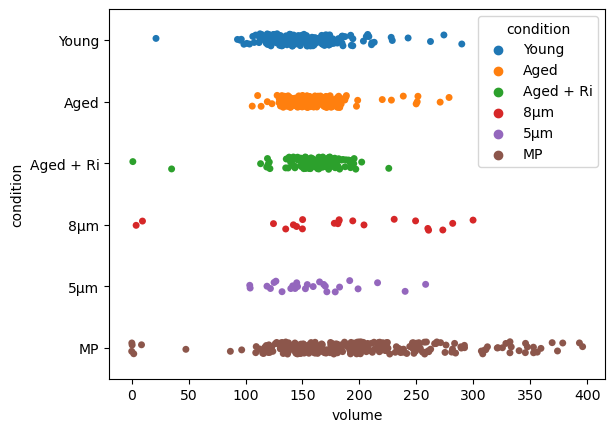

In [17]:
sns.stripplot(
    data=nuc_df,
    x="volume",
    y="condition",
    hue="condition",
    dodge=False,
    zorder=1,
)

In [18]:
nuc_df.columns

Index(['equivalent_diameter', 'feret_diameter_max', 'bbox-0', 'bbox-1',
       'bbox-2', 'bbox-3', 'bbox-4', 'bbox-5', 'centroid-0', 'centroid-1',
       'centroid-2', 'major_axis_length', 'minor_axis_length',
       'mean_intensity', 'min_intensity', 'max_intensity', 'label', 'solidity',
       'volume', 'bbox_volume', 'convex_volume', 'filled_volume', 'width',
       'length', 'height', 'height_deviation', 'elongation', 'aspect_ratio',
       'invagination_prop', 'surface_area', 'sphericity', 'surface/volume',
       'int_0.0-0.5', 'int_1.0-1.5', 'int_ratio', '2D_slide_area',
       '2D_slide_bbox-0', '2D_slide_bbox-1', '2D_slide_bbox-2',
       '2D_slide_bbox-3', '2D_slide_centroid-0', '2D_slide_centroid-1',
       '2D_slide_eccentricity', '2D_slide_major_axis_length',
       '2D_slide_minor_axis_length', '2D_slide_perimeter',
       '2D_slide_perimeter_crofton', '2D_slide_equivalent_diameter',
       '2D_slide_feret_diameter_max', '2D_slide_roundness',
       '2D_slide_compactness'

<Axes: xlabel='2D_slide_EOP', ylabel='condition'>

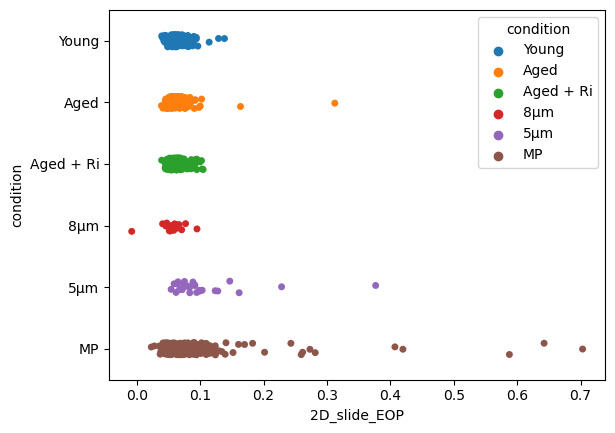

In [19]:
sns.stripplot(
    data=nuc_df,
    x="2D_slide_EOP",
    y="condition",
    hue="condition",
    dodge=False,
    zorder=1,
)

In [20]:
# Identify the "splashed cells" that occupy the whole image grid
nuc_df.query("volume > 400")

,equivalent_diameter,feret_diameter_max,bbox-0,bbox-1,bbox-2,bbox-3,bbox-4,bbox-5,centroid-0,centroid-1,...,DIRs_n,DIRs_centroid_distance2border,DIRs_mean_distance2border,DIRs_min_distance2border,res_Z,sigma_noise,im_path,im_batch,im_nuc,condition


In [21]:
# Remove artifacts created by the segmentation which are too small to be nuclei
# these are exactly the images that were not standardized properly
nuc_df.query("volume < 40").im_path.unique()

array(['3D_res=0.1_norm=z_score_npz_filt/young/20201119expYH3k9me2AF488_nuc_16.npz',
       '3D_res=0.1_norm=z_score_npz_filt/aged_treated_RhoAi/20201218expSlide9A1+RiTazCy3_nuc_43.npz',
       '3D_res=0.1_norm=z_score_npz_filt/aged_treated_RhoAi/20201218expAg1+RiH3K9me2_2_nuc_33.npz',
       '3D_res=0.1_norm=z_score_npz_filt/young_compressed_8um/20220527exp_20220615_8umRhoGTPTAZ_nuc_2_8um.npz',
       '3D_res=0.1_norm=z_score_npz_filt/young_compressed_8um/20220530exp_20220615_8umRhoGTPTAZlooks like 8_nuc_62_8um.npz',
       '3D_res=0.1_norm=z_score_npz_filt/myeloid_progenitors/20210916_KDM3A_2_nuc_118.npz',
       '3D_res=0.1_norm=z_score_npz_filt/myeloid_progenitors/20210916_KDM3A_2_nuc_114.npz',
       '3D_res=0.1_norm=z_score_npz_filt/myeloid_progenitors/20211203_KDM3A_nuc_86.npz',
       '3D_res=0.1_norm=z_score_npz_filt/myeloid_progenitors/20210122_PHF8-NewAB_nuc_50.npz',
       '3D_res=0.1_norm=z_score_npz_filt/myeloid_progenitors/20210916_KDM3A_2_nuc_113.npz'],
      dtype=obje

In [22]:
# Three of these are also images with volume > 400
nuc_df.query("DIRs_volume > 5").im_path.unique()

array(['3D_res=0.1_norm=z_score_npz_filt/young_compressed_8um/20220527exp_20220615_8umRhoGTPTAZ_nuc_1_8um.npz',
       '3D_res=0.1_norm=z_score_npz_filt/young_compressed_5um/20220510exp_220519_conf4.8_2_nuc_13_5um.npz',
       '3D_res=0.1_norm=z_score_npz_filt/young_compressed_5um/20220510exp_220519_conf4.8_2_nuc_15_5um.npz',
       '3D_res=0.1_norm=z_score_npz_filt/myeloid_progenitors/20210120_PHF8-OldAB_nuc_60.npz',
       '3D_res=0.1_norm=z_score_npz_filt/myeloid_progenitors/20210120_PHF8-OldAB_nuc_25.npz'],
      dtype=object)

In [23]:
nuc_df.query("`2D_slide_EOP` > 0.25").im_path.unique()

array(['3D_res=0.1_norm=z_score_npz_filt/aged/20191128PlaminAged_nuc_10.npz',
       '3D_res=0.1_norm=z_score_npz_filt/young_compressed_5um/20220525exp_20220610_RhoGTPTAZ_B_5um_nuc_48_5um.npz',
       '3D_res=0.1_norm=z_score_npz_filt/myeloid_progenitors/20210121_PHF8-NewAB_nuc_43.npz',
       '3D_res=0.1_norm=z_score_npz_filt/myeloid_progenitors/20210120_PHF8-OldAB_nuc_57.npz',
       '3D_res=0.1_norm=z_score_npz_filt/myeloid_progenitors/20210120_PHF8-OldAB_nuc_53.npz',
       '3D_res=0.1_norm=z_score_npz_filt/myeloid_progenitors/20210122_PHF8-NewAB_nuc_52.npz',
       '3D_res=0.1_norm=z_score_npz_filt/myeloid_progenitors/20210114_KDM4B_nuc_15.npz',
       '3D_res=0.1_norm=z_score_npz_filt/myeloid_progenitors/20210120_PHF8-OldAB_nuc_65.npz',
       '3D_res=0.1_norm=z_score_npz_filt/myeloid_progenitors/20210114_KDM4B_nuc_20.npz',
       '3D_res=0.1_norm=z_score_npz_filt/myeloid_progenitors/20210126_KDM4A_nuc_46.npz',
       '3D_res=0.1_norm=z_score_npz_filt/myeloid_progenitors/20210120

In [24]:
bad_imgs = nuc_df.query("`2D_slide_EOP` > 0.25").im_path.unique()
bad_imgs = "../data/preprocessed/3" + bad_imgs
bad_imgs

array(['../data/preprocessed/33D_res=0.1_norm=z_score_npz_filt/aged/20191128PlaminAged_nuc_10.npz',
       '../data/preprocessed/33D_res=0.1_norm=z_score_npz_filt/young_compressed_5um/20220525exp_20220610_RhoGTPTAZ_B_5um_nuc_48_5um.npz',
       '../data/preprocessed/33D_res=0.1_norm=z_score_npz_filt/myeloid_progenitors/20210121_PHF8-NewAB_nuc_43.npz',
       '../data/preprocessed/33D_res=0.1_norm=z_score_npz_filt/myeloid_progenitors/20210120_PHF8-OldAB_nuc_57.npz',
       '../data/preprocessed/33D_res=0.1_norm=z_score_npz_filt/myeloid_progenitors/20210120_PHF8-OldAB_nuc_53.npz',
       '../data/preprocessed/33D_res=0.1_norm=z_score_npz_filt/myeloid_progenitors/20210122_PHF8-NewAB_nuc_52.npz',
       '../data/preprocessed/33D_res=0.1_norm=z_score_npz_filt/myeloid_progenitors/20210114_KDM4B_nuc_15.npz',
       '../data/preprocessed/33D_res=0.1_norm=z_score_npz_filt/myeloid_progenitors/20210120_PHF8-OldAB_nuc_65.npz',
       '../data/preprocessed/33D_res=0.1_norm=z_score_npz_filt/myeloid_

In [25]:
# nuc_df = nuc_df.query(
#    "volume > 40 and DIRs_volume < 5 and mean_intensity < 0.001 and mean_intensity > -0.001"
# )
nuc_df = nuc_df.query(
    "volume > 40  and DIRs_volume < 5 and `2D_slide_EOP` < 0.25"
)

In [26]:
nuc_df.shape

(837, 92)

In [27]:
# Save the pandas dataframe as a csv file
nuc_df.to_csv(f"results/{norm}_nuclei_3d_res{res}_cf{cft}_filt_df.csv")